In [3]:
from keras_vggface.vggface import VGGFace
from keras.models import Model
from keras.layers import Input, AveragePooling2D, Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.callbacks import CSVLogger
from keras import backend as K
from keras.constraints import Constraint
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

In [2]:
input_tensor = Input(shape=(224, 224, 3))
base_model = VGGFace(model='resnet50', input_tensor=input_tensor, include_top=False)

In [3]:
for layer in base_model.layers:
    layer.trainable=False

x = base_model.output
x = AveragePooling2D(pool_size=(7,7), padding='same')(x)
x = Flatten(name="flatten")(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(7, activation="softmax")(x)

updatedModel = Model(base_model.input, x)
updatedModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

In [4]:
train_folder = "../Train"
val_folder = "../Val"

train_datagen = ImageDataGenerator(horizontal_flip=True)
val_datagen = ImageDataGenerator(horizontal_flip=True)

In [5]:
train_batchsize = 32
val_batchsize = 8
IMAGE_SIZE = 224

train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode="categorical",
        shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [6]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1 , patience = 10)

csv_logger = CSVLogger('resnet_training.log', separator=',', append=False)
callbacks_list = [reduce_lr, csv_logger]

In [7]:
num_epochs = 200
learning_rate = 1e-4
sgd = SGD(lr=learning_rate, momentum = 0.9)
updatedModel.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['acc'])

In [9]:
history = updatedModel.fit_generator(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)

updatedModel.save('../saves/ResNet50.hdf5')

Epoch 1/200
898/898 [==============================] - 223s 248ms/step - loss: 2.2641 - acc: 0.2857 - val_loss: 2.0692 - val_acc: 0.4018s: 2
Epoch 2/200
898/898 [==============================] - 215s 240ms/step - loss: 1.6215 - acc: 0.3824 - val_loss: 1.8712 - val_acc: 0.4369
Epoch 3/200
898/898 [==============================] - 216s 240ms/step - loss: 1.5103 - acc: 0.4238 - val_loss: 1.6929 - val_acc: 0.4609
Epoch 4/200
898/898 [==============================] - 215s 240ms/step - loss: 1.4398 - acc: 0.4518 - val_loss: 1.9555 - val_acc: 0.4773
Epoch 5/200
898/898 [==============================] - 216s 240ms/step - loss: 1.3838 - acc: 0.4748 - val_loss: 1.9201 - val_acc: 0.4954
Epoch 6/200
898/898 [==============================] - 216s 240ms/step - loss: 1.3463 - acc: 0.4906 - val_loss: 2.0090 - val_acc: 0.4957
Epoch 7/200
898/898 [==============================] - 216s 240ms/step - loss: 1.3146 - acc: 0.5073 - val_loss: 2.0258 - val_acc: 0.5065
Epoch 8/200
898/898 [================

898/898 [==============================] - 215s 239ms/step - loss: 1.1621 - acc: 0.5707 - val_loss: 1.9360 - val_acc: 0.5233s
Epoch 118/200
898/898 [==============================] - 215s 240ms/step - loss: 1.1699 - acc: 0.5638 - val_loss: 2.1174 - val_acc: 0.5208
Epoch 119/200
898/898 [==============================] - 215s 239ms/step - loss: 1.1628 - acc: 0.5647 - val_loss: 1.9881 - val_acc: 0.5266s - loss: - ETA: 1s - loss: 1.1615 - acc:
Epoch 120/200
898/898 [==============================] - 215s 239ms/step - loss: 1.1625 - acc: 0.5640 - val_loss: 2.1363 - val_acc: 0.5277
Epoch 121/200
898/898 [==============================] - 215s 240ms/step - loss: 1.1642 - acc: 0.5663 - val_loss: 2.2400 - val_acc: 0.5272
Epoch 122/200
898/898 [==============================] - 215s 240ms/step - loss: 1.1606 - acc: 0.5659 - val_loss: 2.1182 - val_acc: 0.5280
Epoch 123/200
898/898 [==============================] - 215s 240ms/step - loss: 1.1673 - acc: 0.5651 - val_loss: 2.1099 - val_acc: 0.5283

# Plot


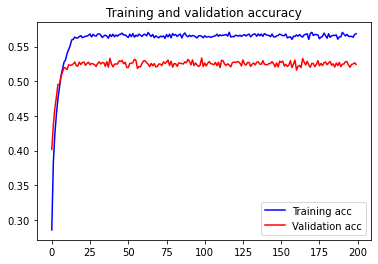

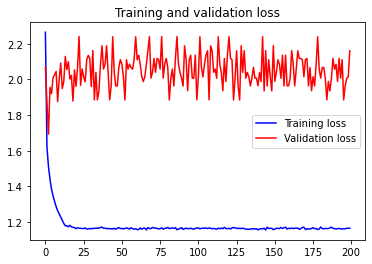

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fase TEST

In [1]:
import random
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns

In [12]:
def show_confusion_matrix(validations, predictions, labels):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [13]:
test_folder = "../Test"
IMAGE_SIZE = 224
random.seed(3)
test_batchsize = 1

In [14]:
model = load_model('../saves/ResNet50.hdf5')

In [20]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 3589 images belonging to 7 classes.


In [21]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v, k) for k, v in label2index.items())

In [22]:
predictions = model.predict_generator(test_generator,
                      steps=test_generator.samples / test_generator.batch_size,
                      verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

3589/3589 [==============================] - 76s 21ms/step


No of errors = 1617/3589


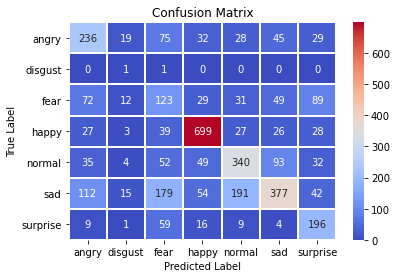

              precision    recall  f1-score   support

           0       0.48      0.51      0.49       464
           1       0.02      0.50      0.04         2
           2       0.23      0.30      0.26       405
           3       0.80      0.82      0.81       849
           4       0.54      0.56      0.55       605
           5       0.63      0.39      0.48       970
           6       0.47      0.67      0.55       294

    accuracy                           0.55      3589
   macro avg       0.45      0.54      0.46      3589
weighted avg       0.58      0.55      0.55      3589



In [23]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), test_generator.samples))
labels = ["angry", "disgust", "fear", "happy", "normal", "sad", "surprise"]
show_confusion_matrix(predicted_classes, ground_truth, labels)
print(classification_report(predicted_classes, ground_truth))

# Fase SPARSE

In [30]:
from keras.layers import deserialize as layer_from_config
from keras.models import model_from_config
from keras.models import Model

from keras.layers import Input, AveragePooling2D, Dense, Dropout, Flatten

In [67]:
model =  load_model('../saves/ResNet50.hdf5')
input_tensor = Input(shape=(224, 224, 3))
sparse_model = VGGFace(model='resnet50', input_tensor=input_tensor, include_top=False)

In [5]:
layers = sparse_model.layers
pos = []
val = 0
for layer in layers:
    string = str(layer)
    if 'Conv2D' in string:
        pos.append(val)
    val = val + 1
print(pos)

config = sparse_model.get_config()

[1, 5, 8, 11, 12, 17, 20, 23, 27, 30, 33, 37, 40, 43, 44, 49, 52, 55, 59, 62, 65, 69, 72, 75, 79, 82, 85, 86, 91, 94, 97, 101, 104, 107, 111, 114, 117, 121, 124, 127, 131, 134, 137, 141, 144, 147, 148, 153, 156, 159, 163, 166, 169]


In [36]:
print(config['layers'][0])

{'name': 'input_2', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 224, 224, 3), 'dtype': 'float32', 'sparse': False, 'name': 'input_2'}, 'inbound_nodes': []}


In [6]:
class Sparse(Constraint):
    def __init__(self, mask):
        self.mask = K.cast_to_floatx(mask)
    
    def __call__(self,x):
        return self.mask * x
    
    def get_config(self):
        return {'mask': self.mask}

In [7]:
def create_sparsity_masks(model,sparsity):
    weights_list = model.get_weights()
    masks = []
    for weights in weights_list:
        #We can ignore biases
        if len(weights.shape) > 1:
            weights_abs = np.abs(weights)
            masks.append((weights_abs>np.percentile(weights_abs,sparsity))*1.)
    return masks

In [8]:
masks = create_sparsity_masks(model,60)

In [68]:
x = sparse_model.output
x = AveragePooling2D(pool_size=(7, 7), padding='same')(x)
x = Flatten(name="flatten")(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(7, activation="softmax")(x)

sparse_model= Model(sparse_model.input, x)

In [69]:
layers = sparse_model.layers
layers = layers[0:173]
for layer in layers:
    layer.trainable=False
    
count = 0
for n in pos:
    layers[n].kernel_constraint = Sparse(masks[count])
    count = count + 1

sparse_model.set_weights(model.get_weights())

sparse_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_6[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_246 (Activation)     (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

In [16]:
train_folder = "C:/Users/nico9/Desktop/FaceDetection/Train"
val_folder = "C:/Users/nico9/Desktop/FaceDetection/Val"

train_datagen = ImageDataGenerator(horizontal_flip=True)
val_datagen = ImageDataGenerator(horizontal_flip=True)

In [17]:
train_batchsize = 32
val_batchsize = 8
IMAGE_SIZE = 224
train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode="categorical",
        shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [18]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1 , patience = 10)

csv_logger = CSVLogger('resnet_sparse_training.log', separator=',', append=False)
callbacks_list = [reduce_lr, csv_logger]

In [ ]:
log = pd.read_csv('../notebook/resnet_training.log')
dim = len(log['lr'])
lr = log['lr']

In [ ]:
num_epochs = 50
learning_rate = lr[dim-1]
sgd = SGD(lr=learning_rate, momentum = 0.9)
sparse_model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['acc'])

In [ ]:
history = sparse_model.fit_generator(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)
sparse_model.save('../saves/resnet_sparse_model.hdf5')

# Plot fase Sparse

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test fase Sparse

In [ ]:
import random
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
def show_confusion_matrix(validations, predictions, labels):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
test_folder = "../Test"
IMAGE_SIZE = 224
random.seed(3)
test_batchsize = 1

In [ ]:
model = load_model('../saves/resnet_sparse_model.hdf5')

In [ ]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

In [ ]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v, k) for k, v in label2index.items())

In [ ]:
predictions = model.predict_generator(test_generator,
                      steps=test_generator.samples / test_generator.batch_size,
                      verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), test_generator.samples))
labels = ["angry", "disgust", "fear", "happy", "normal", "sad", "surprise"]
show_confusion_matrix(predicted_classes, ground_truth, labels)
print(classification_report(predicted_classes, ground_truth))

# Seconda fase Dense

In [ ]:
sparse_model = load_model('../saves/resnet_sparse_model.hdf5')
input_tensor = Input(shape=(224, 224, 3))
base_model = VGGFace(model='resnet50', input_tensor=input_tensor, include_top=False)

In [ ]:
for layer in base_model.layers:
    layer.trainable=False

x = base_model.output
x = AveragePooling2D(pool_size=(7,7), padding='same')(x)
x = Flatten(name="flatten")(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(7, activation="softmax")(x)

updatedModel = Model(base_model.input, x)
updatedModel.set_weights(sparse_model.get_weights())
updatedModel.summary()


In [ ]:
train_folder = "../Train"
val_folder = "../Val"

train_datagen = ImageDataGenerator(horizontal_flip=True)
val_datagen = ImageDataGenerator(horizontal_flip=True)

In [ ]:
train_batchsize = 32
val_batchsize = 8

train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode="categorical",
        shuffle=False
)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1 , patience = 10)

csv_logger = CSVLogger('redense_resnet_training.log', separator=',', append=False)
callbacks_list = [reduce_lr, csv_logger]

In [ ]:
log = pd.read_csv('../notebook/resnet_sparse_training.log')
dim = len(log['lr'])
lr = log['lr']

In [ ]:
num_epochs = 50
learning_rate = lr[dim-1]
sgd = SGD(lr=learning_rate, momentum = 0.9)
updatedModel.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['acc'])

In [ ]:
history = updatedModel.fit_generator(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)

updatedModel.save('../saves/redense_ResNet50.hdf5')

# Plot seconda fase Dense

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test seconda fase Dense

In [ ]:
import random
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
def show_confusion_matrix(validations, predictions, labels):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
test_folder = "../Test"
IMAGE_SIZE = 224
random.seed(3)
test_batchsize = 1

In [ ]:
model = load_model('../saves/redense_ResNet50.hdf5')

In [ ]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

In [ ]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v, k) for k, v in label2index.items())

In [ ]:
predictions = model.predict_generator(test_generator,
                      steps=test_generator.samples / test_generator.batch_size,
                      verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), test_generator.samples))
labels = ["angry", "disgust", "fear", "happy", "normal", "sad", "surprise"]
show_confusion_matrix(predicted_classes, ground_truth, labels)
print(classification_report(predicted_classes, ground_truth))

# Seconda fase Sparse

In [ ]:
model =  load_model('../saves/redense_ResNet50.hdf5')
input_tensor = Input(shape=(224, 224, 3))
sparse_model = VGGFace(model='resnet50', input_tensor=input_tensor, include_top=False)

In [ ]:
layers = sparse_model.layers
pos = []
val = 0
for layer in layers:
    string = str(layer)
    if 'Conv2D' in string:
        pos.append(val)
    val = val + 1
print(pos)

config = sparse_model.get_config()

In [ ]:
class Sparse(Constraint):
    def __init__(self, mask):
        self.mask = K.cast_to_floatx(mask)
    
    def __call__(self,x):
        return self.mask * x
    
    def get_config(self):
        return {'mask': self.mask}

In [ ]:
def create_sparsity_masks(model,sparsity):
    weights_list = model.get_weights()
    masks = []
    for weights in weights_list:
        #We can ignore biases
        if len(weights.shape) > 1:
            weights_abs = np.abs(weights)
            masks.append((weights_abs>np.percentile(weights_abs,sparsity))*1.)
    return masks

In [ ]:
masks = create_sparsity_masks(model,60)

In [ ]:
x = sparse_model.output
x = AveragePooling2D(pool_size=(7, 7), padding='same')(x)
x = Flatten(name="flatten")(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(7, activation="softmax")(x)

sparse_model= Model(sparse_model.input, x)

In [ ]:
layers = sparse_model.layers
layers = layers[0:173]
for layer in layers:
    layer.trainable=False
    
count = 0
for n in pos:
    layers[n].kernel_constraint = Sparse(masks[count])
    count = count + 1

sparse_model.set_weights(model.get_weights())

sparse_model.summary()

In [ ]:
train_folder = "C:/Users/nico9/Desktop/FaceDetection/Train"
val_folder = "C:/Users/nico9/Desktop/FaceDetection/Val"

train_datagen = ImageDataGenerator(horizontal_flip=True)
val_datagen = ImageDataGenerator(horizontal_flip=True)

In [ ]:
train_batchsize = 32
val_batchsize = 8
IMAGE_SIZE = 224
train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode="categorical",
        shuffle=False
)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1 , patience = 10)

csv_logger = CSVLogger('resnet_sparse2_training.log', separator=',', append=False)
callbacks_list = [reduce_lr, csv_logger]

In [ ]:
log = pd.read_csv('../notebook/redense_resnet_training.log')
dim = len(log['lr'])
lr = log['lr']

In [ ]:
num_epochs = 50
learning_rate = lr[dim-1]
sgd = SGD(lr=learning_rate, momentum = 0.9)
sparse_model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['acc'])

In [ ]:
history = sparse_model.fit_generator(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)
sparse_model.save('../saves/resnet_sparse2_model.hdf5')

# Plot seconda fase Sparse

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test seconda fase Sparse

In [ ]:
import random
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
def show_confusion_matrix(validations, predictions, labels):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
test_folder = "../Test"
IMAGE_SIZE = 224
random.seed(3)
test_batchsize = 1

In [ ]:
model = load_model('../saves/resnet_sparse2_model.hdf5')

In [ ]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

In [ ]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v, k) for k, v in label2index.items())

In [ ]:
predictions = model.predict_generator(test_generator,
                      steps=test_generator.samples / test_generator.batch_size,
                      verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), test_generator.samples))
labels = ["angry", "disgust", "fear", "happy", "normal", "sad", "surprise"]
show_confusion_matrix(predicted_classes, ground_truth, labels)
print(classification_report(predicted_classes, ground_truth))

# Terza fase Dense

In [ ]:
sparse_model = load_model('../saves/resnet_sparse2_model.hdf5')
input_tensor = Input(shape=(224, 224, 3))
base_model = VGGFace(model='resnet50', input_tensor=input_tensor, include_top=False)

In [ ]:
for layer in base_model.layers:
    layer.trainable=False

x = base_model.output
x = AveragePooling2D(pool_size=(7,7), padding='same')(x)
x = Flatten(name="flatten")(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(7, activation="softmax")(x)

updatedModel = Model(base_model.input, x)
updatedModel.set_weights(sparse_model.get_weights())
updatedModel.summary()


In [ ]:
train_folder = "../Train"
val_folder = "../Val"

train_datagen = ImageDataGenerator(horizontal_flip=True)
val_datagen = ImageDataGenerator(horizontal_flip=True)

In [ ]:
train_batchsize = 32
val_batchsize = 8

train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode="categorical",
        shuffle=False
)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1 , patience = 10)

csv_logger = CSVLogger('dense3_resnet_training.log', separator=',', append=False)
callbacks_list = [reduce_lr, csv_logger]

In [ ]:
log = pd.read_csv('../notebook/resnet_sparse2_training.log')
dim = len(log['lr'])
lr = log['lr']

In [ ]:
num_epochs = 50
learning_rate = lr[dim-1]
sgd = SGD(lr=learning_rate, momentum = 0.9)
updatedModel.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['acc'])

In [ ]:
history = updatedModel.fit_generator(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    verbose=1,
    callbacks=callbacks_list
)

updatedModel.save('../saves/dense3_ResNet50.hdf5')

# Plot terza fase Dense

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test terza Dense

In [ ]:
import random
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
def show_confusion_matrix(validations, predictions, labels):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
test_folder = "../Test"
IMAGE_SIZE = 224
random.seed(3)
test_batchsize = 1

In [ ]:
model = load_model('../saves/dense3_ResNet50.hdf5')

In [ ]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

In [ ]:
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v, k) for k, v in label2index.items())

In [ ]:
predictions = model.predict_generator(test_generator,
                      steps=test_generator.samples / test_generator.batch_size,
                      verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), test_generator.samples))
labels = ["angry", "disgust", "fear", "happy", "normal", "sad", "surprise"]
show_confusion_matrix(predicted_classes, ground_truth, labels)
print(classification_report(predicted_classes, ground_truth))